In [6]:
import pandas as pd
from pycaret.regression import RegressionExperiment
import os
import psycopg2

In [ ]:
requete = f"""SELECT test.film."primaryTitle" , "startYear" ,"runtimeMinutes" ,
split_part("genres", ',', 1) AS genre_1,
split_part("genres", ',', 2) AS genre_2,
split_part("genres", ',', 3) AS genre_3,
test.ratings."numVotes", test.ratings."averageRating"
FROM test.film 
join test.ratings on test.ratings.tconst = test.film.tconst 
and "startYear" != '\\N'  -- Escaping the backslash
and cast("startYear" as int) > 2000
and "titleType" = 'movie'
and "isAdult" = '0';"""

#Load manuel des variable de l'environement car le module ne fonctionne pas
def load_dotenv(filepath):
    """Manually load environment variables from a .env file."""
    with open(filepath) as f:
        for line in f:
            # Ignore empty lines and comments (lines starting with '#')
            line = line.strip()
            if line and not line.startswith("#"):
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()


#Réécriture de la fonction de connection
def se_connecter_a_la_base_de_donnees():
        load_dotenv('.env')
        """Connexion à la base de données PostgreSQL."""
        host = os.getenv("HOST")
        port = os.getenv("PORT")
        utilisateur = os.getenv("USER")
        mot_de_passe = os.getenv("PASSWORD")
        nom_base_de_donnees = "postgres"

        try:
            connexion = psycopg2.connect(
                dbname=nom_base_de_donnees,
                user=utilisateur,
                password=mot_de_passe,
                host=host,
                port=port
            )
            print("Connexion réussie à la base de données")
            return connexion
        except psycopg2.Error as e:
            print(f"Erreur lors de la connexion à la base de données: {e}")
            return None





#Recupere un dataframe qui est pret a etre utiliser dans un modele type pycaret
def GetFrame():
    connection = se_connecter_a_la_base_de_donnees()
    frame = None
    if(connection):

        curseur = connection.cursor()
        try:
            curseur.execute(requete)
            frame = pd.DataFrame(curseur.fetchall())
            frame.columns = ['movieName', 'launchYear', 'runTimemins', 'genre_1','genre_2','genre_3',"numVotes","avgNote"]
            frame["avgNote"]=frame["avgNote"].apply(float)
        except:
            pass
        finally:
            curseur.close()
            connection.close()
            print("Connection fermer")
    return frame

data = GetFrame()



Connexion réussie à la base de données
Connection fermer


In [19]:
s = RegressionExperiment()
s.setup(data, target = 'avgNote', session_id = 123)

,Description,Value
0,Session id,123
1,Target,avgNote
2,Target type,Regression
3,Original data shape,"(187746, 8)"
4,Transformed data shape,"(187746, 103)"
5,Transformed train set shape,"(131422, 103)"
6,Transformed test set shape,"(56324, 103)"
7,Categorical features,7
8,Preprocess,True
9,Imputation type,simple


In [20]:
best = s.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,1.0789,1.9251,1.3875,0.1409,0.2154,0.2104,9.7350
et,Extra Trees Regressor,1.1079,2.0641,1.4366,0.0789,0.2251,0.2205,130.0920
rf,Random Forest Regressor,1.1159,2.0757,1.4406,0.0738,0.2256,0.2219,59.6940
ada,AdaBoost Regressor,1.1649,2.1385,1.4622,0.0458,0.2259,0.2242,18.2830
lightgbm,Light Gradient Boosting Machine,1.1531,2.1611,1.4700,0.0356,0.2295,0.2280,2.4070
lasso,Lasso Regression,1.1862,2.2410,1.4970,-0.0001,0.2324,0.2347,1.7200
dummy,Dummy Regressor,1.1862,2.2410,1.4970,-0.0001,0.2324,0.2347,1.6540
llar,Lasso Least Angle Regression,1.1862,2.2410,1.4970,-0.0001,0.2324,0.2347,1.8800
en,Elastic Net,1.1862,2.2410,1.4970,-0.0001,0.2324,0.2347,1.7120
gbr,Gradient Boosting Regressor,1.1858,2.2580,1.5026,-0.0076,0.2334,0.2326,22.6190


In [24]:
# OOP API
s.save_model(best, 'my_best_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=[], transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['movieName', 'launchYear',
                                              'runTimemins', 'genre_1',
                                              'genre_2', 'genre_3', 'numVotes'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('onehot_encoding',
                  TransformerWrapper(...
                                     transformer=OneHotEncoder(cols=['launchYear',
                                                                     'genre_1',
                                                                     'genre_2',
                                                                     'genre_3'],
                                                               handle_missing='r

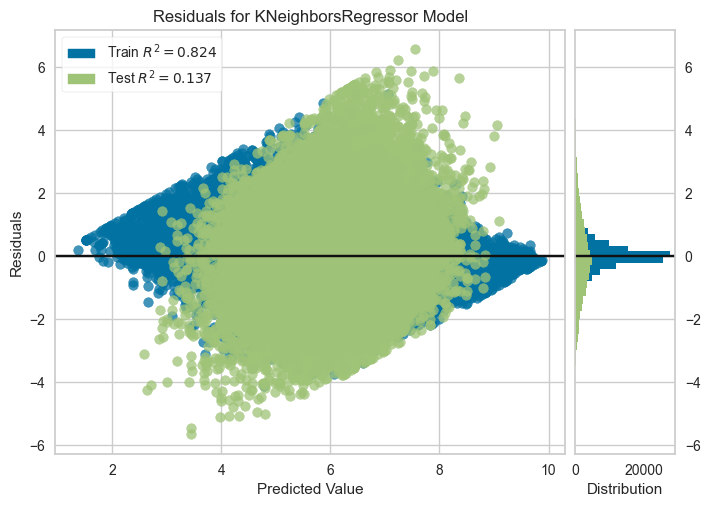

In [25]:
# OOP API
s.plot_model(best, plot = 'residuals')

In [36]:
# OOP API
dataReturn = s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,1.0822,1.9326,1.3902,0.1371,0.2148,0.2096


In [35]:
testData = pd.DataFrame([["Un indien a paris",2015,93,"Comedy","Documentary","",845694],
                         ["bla",2008,13,"Thriller","","",45986]])
testData.columns = ['movieName', 'launchYear', 'runTimemins', 'genre_1','genre_2','genre_3',"numVotes"]
s.predict_model(best,data=testData) 


,movieName,launchYear,runTimemins,genre_1,genre_2,genre_3,numVotes,prediction_label
0,Un indien a paris,2015,93,Comedy,Documentary,,845694,6.820001
1,bla,2008,13,Thriller,,,45986,6.220000
